In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

print("Imports OK ✅")

Imports OK ✅


In [39]:
# 1. Load Data
filename = "/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/NB6 - Gradient Descent/Fraud_detection.csv"
df = pd.read_csv(filename)
df_clean = df.dropna()

print(f"Dataset shape: {df_clean.shape}")

# 2. Identify Amount Column
# We need to extract the Amount BEFORE splitting to ensure we don't lose track of it
if "Amount" in df_clean.columns:
    AMOUNT_COL = "Amount"
elif "amount" in df_clean.columns:
    AMOUNT_COL = "amount"
else:
    # Fallback: try to find the first numeric column that isn't the target
    cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if "target" in cols:
        cols.remove("target")
    AMOUNT_COL = cols[0]

print(f"Using '{AMOUNT_COL}' as the transaction amount column.")

# 3. Split Data (X, y, and Amounts)
# We split X and y as usual, but we also need to split the Amounts array
# so it matches the X/y indices exactly.
X = df_clean.drop(columns=["target"]).values
y = df_clean["target"].values
amounts = df_clean[AMOUNT_COL].values

# Train/Temp Split
X_tr, X_tmp, y_tr, y_tmp, amt_tr, amt_tmp = train_test_split(
    X, y, amounts, test_size=0.2, random_state=42, stratify=y
)

# Val/Test Split
X_va, X_te, y_va, y_te, amt_va, amt_te = train_test_split(
    X_tmp, y_tmp, amt_tmp, test_size=0.5, random_state=43, stratify=y_tmp
)

# 4. Convert to PyTorch Tensors
# Note: We need amounts as float32 for the loss calculation
X_train_t = torch.tensor(X_tr, dtype=torch.float32)
y_train_t = torch.tensor(y_tr, dtype=torch.float32)  # Float needed for custom loss
amt_train_t = torch.tensor(amt_tr, dtype=torch.float32)

X_val_t = torch.tensor(X_va, dtype=torch.float32)
y_val_t = torch.tensor(y_va, dtype=torch.float32)
amt_val_t = torch.tensor(amt_va, dtype=torch.float32)

X_test_t = torch.tensor(X_te, dtype=torch.float32)
y_test_t = torch.tensor(y_te, dtype=torch.float32)
amt_test_t = torch.tensor(amt_te, dtype=torch.float32)

print(f"Train set: {X_train_t.shape}")
print(f"Val set:   {X_val_t.shape}")
print(f"Test set:  {X_test_t.shape}")

Dataset shape: (164492, 30)
Using 'Amount' as the transaction amount column.
Train set: torch.Size([131593, 29])
Val set:   torch.Size([16449, 29])
Test set:  torch.Size([16450, 29])


In [40]:
class ExpectedCostLoss(nn.Module):
    """
    Custom loss function that minimizes total business cost.
    """

    def __init__(
        self, abandonment_limit=0.1, user_lazy_factor=0.2, penalty_per_percent=10000
    ):
        super().__init__()
        self.limit = abandonment_limit
        self.lazy_factor = user_lazy_factor
        # 10,000 EUR penalty for every 1% (0.01) means we multiply by 1,000,000
        # Example: 0.11 - 0.10 = 0.01 * 1,000,000 = 10,000
        self.penalty_scaler = penalty_per_percent * 100

    def forward(self, logits, targets, amounts):
        """
        logits:  (batch_size, 1) Raw outputs
        targets: (batch_size, )  0 for Legit, 1 for Fraud
        amounts: (batch_size, )  Transaction values in EUR
        """
        # 1. Get Probabilities
        probs = torch.sigmoid(logits).squeeze()

        # 2. Authentication Cost
        # We pay ~1 EUR for every high probability assignment
        auth_cost = probs * 1.0

        # 3. Missed Fraud Cost
        # If target=1 and prob=0.1, we miss 0.9 * Amount
        missed_fraud_cost = targets * (1 - probs) * amounts

        # 4. Abandonment Penalty (Global Batch Constraint)
        avg_auth_rate = probs.mean()
        current_abandon_rate = avg_auth_rate * self.lazy_factor

        # ReLU handles the "cliff": if rate < limit, penalty is 0
        excess_abandonment = F.relu(current_abandon_rate - self.limit)
        abandonment_penalty = excess_abandonment * self.penalty_scaler

        # 5. Total Loss
        # We average per-transaction costs and add the global penalty
        total_loss = (auth_cost + missed_fraud_cost).mean() + abandonment_penalty

        return total_loss

In [41]:
class CostOptimizedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # Output 1 scalar (logit)
        )

    def forward(self, x):
        return self.net(x)


# Initialize
model = CostOptimizedNN(input_dim=X_train_t.shape[1])
criterion = ExpectedCostLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200
batch_size = 512
N = X_train_t.shape[0]

# Track losses
train_losses = []
val_losses = []

print("Starting Cost-Sensitive Training...")

for epoch in range(epochs):
    model.train()
    perm = torch.randperm(N)
    total_loss = 0.0

    for start in range(0, N, batch_size):
        idx = perm[start : start + batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]
        ab = amt_train_t[idx]  # Batch amounts

        # Forward
        logits = model(xb)
        loss = criterion(logits, yb, ab)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = total_loss / N
    train_losses.append(avg_train_loss)

    # Validation Check
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = criterion(val_logits, y_val_t, amt_val_t).item()
        val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f} | Val Cost Score: {val_loss:.2f}"
        )

print("Training Complete.")

Starting Cost-Sensitive Training...
Epoch 0: Train Loss: 3.4446 | Val Cost Score: 2.77
Epoch 10: Train Loss: 0.0053 | Val Cost Score: 2.77
Epoch 20: Train Loss: 0.0053 | Val Cost Score: 2.77
Epoch 30: Train Loss: 0.0052 | Val Cost Score: 2.73
Epoch 40: Train Loss: 0.0049 | Val Cost Score: 2.57
Epoch 50: Train Loss: 0.0047 | Val Cost Score: 2.46
Epoch 60: Train Loss: 0.0005 | Val Cost Score: 0.27
Epoch 70: Train Loss: 0.0004 | Val Cost Score: 0.23
Epoch 80: Train Loss: 0.0004 | Val Cost Score: 0.22
Epoch 90: Train Loss: 0.0004 | Val Cost Score: 0.22
Epoch 100: Train Loss: 0.0004 | Val Cost Score: 0.21
Epoch 110: Train Loss: 0.0004 | Val Cost Score: 0.23
Epoch 120: Train Loss: 0.0004 | Val Cost Score: 0.23
Epoch 130: Train Loss: 0.0004 | Val Cost Score: 0.21
Epoch 140: Train Loss: 0.0005 | Val Cost Score: 0.22
Epoch 150: Train Loss: 0.0004 | Val Cost Score: 0.21
Epoch 160: Train Loss: 0.0004 | Val Cost Score: 0.24
Epoch 170: Train Loss: 0.0004 | Val Cost Score: 0.24
Epoch 180: Train Loss

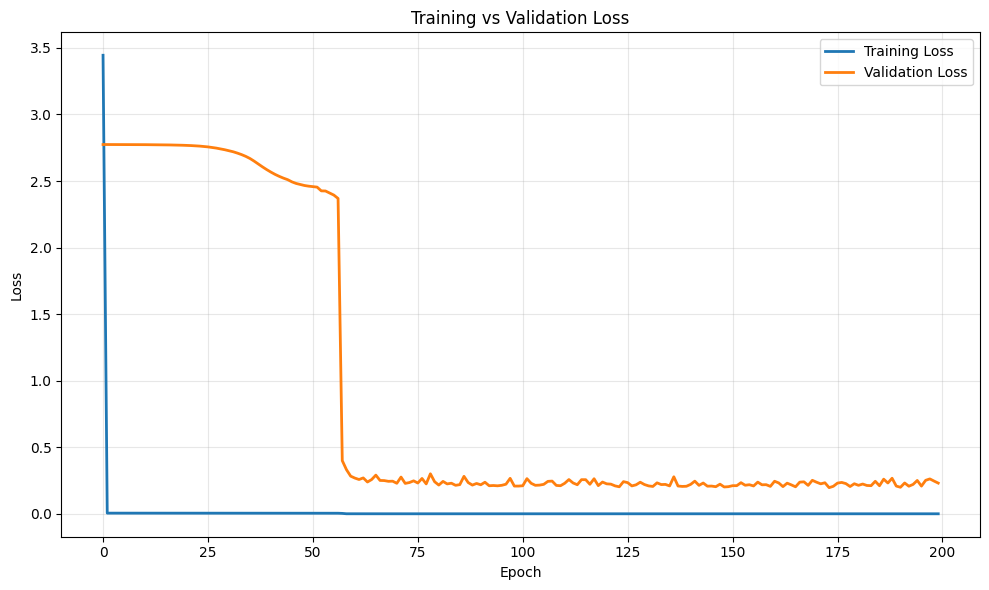


Final Training Loss: 0.0004
Final Validation Loss: 0.23


In [42]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.2f}")

In [ ]:
def calculate_bank_invoice(
    model,
    X_tensor,
    y_true,
    amounts,
    threshold=0.5,
    high_value_threshold=500,
    low_value_threshold=1,
):
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).squeeze().numpy()

    # Make hard decisions based on threshold
    preds = (probs >= threshold).astype(int)

    model_flags = preds.copy()
    model_flag_count = model_flags.sum()

    # Hardcoded rule: Auto-request fraud detection for transactions above high_value_threshold
    high_value_mask = amounts >= high_value_threshold
    preds[high_value_mask] = 1  # Force authentication for high-value transactions

    # Hardcoded rule: Never authenticate transactions below low_value_threshold (not worth the cost)
    low_value_mask = amounts < low_value_threshold
    preds[low_value_mask] = 0  # Skip authentication for low-value transactions

    total_transactions = len(y_true)

    # 1. Authentication Costs
    auth_count = (preds == 1).sum()
    auth_fee = auth_count * 1.0

    # 2. Missed Fraud Costs
    # We let it go (pred=0) but it was fraud (y=1)
    missed_indices = np.where((preds == 0) & (y_true == 1))[0]
    missed_fraud_cost = amounts[missed_indices].sum()

    # 3. Abandonment Penalty
    abandon_rate = (auth_count * 0.2) / total_transactions
    excess = max(0, abandon_rate - 0.10)
    # 10k for every 1% (0.01)
    abandon_penalty = 10000 * (excess * 100)

    total_cost = auth_fee + missed_fraud_cost + abandon_penalty

    high_value_auto_count = high_value_mask.sum()
    low_value_auto_skip = low_value_mask.sum()

    print(f"--- FINAL BANK INVOICE ---")
    print(f"Auth Requested:     {auth_count} (€{auth_fee:.2f})")
    print(f"  ↳ Auto-flagged (>€{high_value_threshold}): {high_value_auto_count}")
    print(f"  ↳ Auto-skipped (<€{low_value_threshold}): {low_value_auto_skip}")
    print(f"Model-flagged Auth Requests: {model_flag_count}")
    print(f"Missed Fraud Cost:  €{missed_fraud_cost:,.2f}")
    print(f"Abandonment Rate:   {abandon_rate:.2%} (Penalty: €{abandon_penalty:,.2f})")
    print(f"--------------------------")
    print(f"TOTAL COST:         €{total_cost:,.2f}")

    return total_cost, preds


# Run Evaluation on Test Set
total_cost, final_preds = calculate_bank_invoice(
    model,
    X_test_t,
    y_te,  # Use the numpy array for y_true
    amt_te,  # Use the numpy array for amounts
)

--- FINAL BANK INVOICE ---
Auth Requested:     2579 (€2579.00)
  ↳ Auto-flagged (>€600): 415
  ↳ Auto-skipped (<€1): 952
Model-flagged Auth Requests: 2583
Missed Fraud Cost:  €1,549.58
Abandonment Rate:   3.14% (Penalty: €0.00)
--------------------------
TOTAL COST:         €4,128.58


In [59]:
# CALCUALATE bank invoice for the entire dataset
total_cost, final_preds = calculate_bank_invoice(
    model,
    torch.tensor(X, dtype=torch.float32),
    y,  # Use the numpy array for y_true
    amounts,  # Use the numpy array for amounts
    threshold=0.004,
    high_value_threshold=3000,
    low_value_threshold=1,
)

--- FINAL BANK INVOICE ---
Auth Requested:     25515 (€25515.00)
  ↳ Auto-flagged (>€3000): 160
  ↳ Auto-skipped (<€1): 9765
Model-flagged Auth Requests: 25571
Missed Fraud Cost:  €12,579.67
Abandonment Rate:   3.10% (Penalty: €0.00)
--------------------------
TOTAL COST:         €38,094.67
